In [1]:
import numpy as np
import scipy.sparse as sps
import scipy.linalg as spl
import scipy.sparse.linalg as spsl

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
import xarray as xr
%matplotlib inline
matplotlib.rcParams.update({'font.size':15})

import time

from analysisTools import *

The goal of this notebook is to show that the eigenvalues of the following homogeneous equation:
$$\partial_y^2 \tilde b_\theta'' + \left[\dfrac{C^2y^2 + mC}{M(1-y^2)} - \dfrac{m^2-1}{(1-y^2)^2}\right]\tilde b_\theta'' = 0$$
on the interval $[-1,1]$, come in pairs of symmetric and antisymmetric modes with nearly equal eigenvalues.

# Functions

In [5]:
def set_y(ngrid,two_hemispheres=False):
    """Sets a y (=cos(latitude)) grid from 0 to 1, nonlinearly spaced, with ngrid points"""
    if two_hemispheres:
        y = np.cos(np.linspace(0.,np.pi,2*ngrid+2)[1:-1][::-1])
        return (y-y[::-1])/2
    else:
        return np.cos(np.linspace(0.,np.pi,2*ngrid+2)[1:-1][::-1][ngrid:]) #exclude the right bound to avoid divisions by 0

def set_A(ngrid,m,M,option=0,two_hemispheres=False,npoints=7):
    """ Sets the matrix A of the wave eigenvalue problem (A - C*In)x = 0
    args :
        - ngrid   : int, number of points in y
        - m       : int, spherical harmonic order 
        - M       : float, nondimensional number scaling Magnetic force vs buoyancy force in the MAC balance
        - npoints : number of points for the finite difference stencil (A contains a second order derivative)
    returns :
        - numpy.ndarray of the same shape as x except along the axis, where its length is incremented by 1
    """
    y  = set_y(ngrid,two_hemispheres)
    D2 = make_D_fornberg(y,2,npoints=npoints) #Matrix of second differentiation
    D2 = (D2 + D2[::-1,::-1])/2
    L1 = -np.dot(np.diag(M*(1-y**2)/(y**2)), D2) + np.diag(M*(m**2-1)/(y**2 * (1-y**2)))
    L2 = -np.diag(m/(y**2))
    
    A=np.block([[np.zeros((len(y),len(y))),np.eye(len(y))],[L1,L2]])
    #Enforce boundary conditions
    A[len(y)] = np.zeros(len(A))
    A[-1]    = np.zeros(len(A))
    scale=np.abs(A[len(y)+1,0])
    if option == 1: #Dirichlet
        A[len(y),0]=   1
        A[-1,len(y)-1]=1
    elif option == 2: #Neumann; second-order one-sided finite difference @ equator
        A[len(y),:3]  = np.array([-3,4,-1])
        A[-1,len(y)-1]= 1
    # The following avoids numerical errors at the boundaries, that appear when the boundary condition is specified too weakly
    A[len(y)] *= scale
    A[-1]    *= scale
    return A

In [14]:
def set_y_old(ngrid,two_hemispheres):
    """Sets a y (=cos(latitude)) grid from 0 to 1, nonlinearly spaced, with ngrid points"""
    if two_hemispheres:
        y = np.cos(np.linspace(0.,np.pi,2*ngrid+2)[1:-1][::-1])
        return y
    else:
        return np.cos(np.linspace(0.,np.pi,2*ngrid+2)[1:-1][::-1][ngrid:]) #exclude the right bound to avoid divisions by 0

def set_A_old(ngrid,m,M,option=0,two_hemispheres=False,npoints=7):
    """ Sets the matrix A of the wave eigenvalue problem (A - C*In)x = 0
    args :
        - ngrid   : int, number of points in y
        - m       : int, spherical harmonic order 
        - M       : float, nondimensional number scaling Magnetic force vs buoyancy force in the MAC balance
        - npoints : number of points for the finite difference stencil (A contains a second order derivative)
    returns :
        - numpy.ndarray of the same shape as x except along the axis, where its length is incremented by 1
    """
    y  = set_y_old(ngrid,two_hemispheres)
    D2 = make_D_fornberg(y,2,npoints=npoints) #Matrix of second differentiation
    L1 = -np.dot(np.diag(M*(1-y**2)/(y**2)), D2) + np.diag(M*(m**2-1)/(y**2 * (1-y**2)))
    L2 = -np.diag(m/(y**2))
    
    A=np.block([[np.zeros((len(y),len(y))),np.eye(len(y))],[L1,L2]])
    #Enforce boundary conditions
    A[len(y)] = np.zeros(len(A))
    A[-1]    = np.zeros(len(A))
    scale=np.abs(A[len(y)+1,0])
    if option == 1: #Dirichlet
        A[len(y),0]=   1
        A[-1,len(y)-1]=1
    elif option == 2: #Neumann; second-order one-sided finite difference @ equator
        A[len(y),:3]  = np.array([-3,4,-1])
        A[-1,len(y)-1]= 1
    # The following avoids numerical errors at the boundaries, that appear when the boundary condition is specified too weakly
    A[len(y)] *= scale
    A[-1]    *= scale
    return A

In [4]:
m=3

# use realistic values
E = 1e-15
Pm = 4.7e-7
Rastar = 8e-5   # From "stochastic generation" (earth-like value)

Hprime=0.062 #Nondimensional layer thickness #0.11 to match simulation
Nprime = 0.583 #0.14/E From "stochastic generation"
Brprime = 3e-5 #np.sqrt(float(layered_s.M_ene_pol.sel(radial_id=310).mean())*2)

fixedparams=(E,Pm,Rastar,Hprime,Nprime,Brprime)

# Symmetric&Antisymmetric Eigenmodes

(-90.0, 90.0)

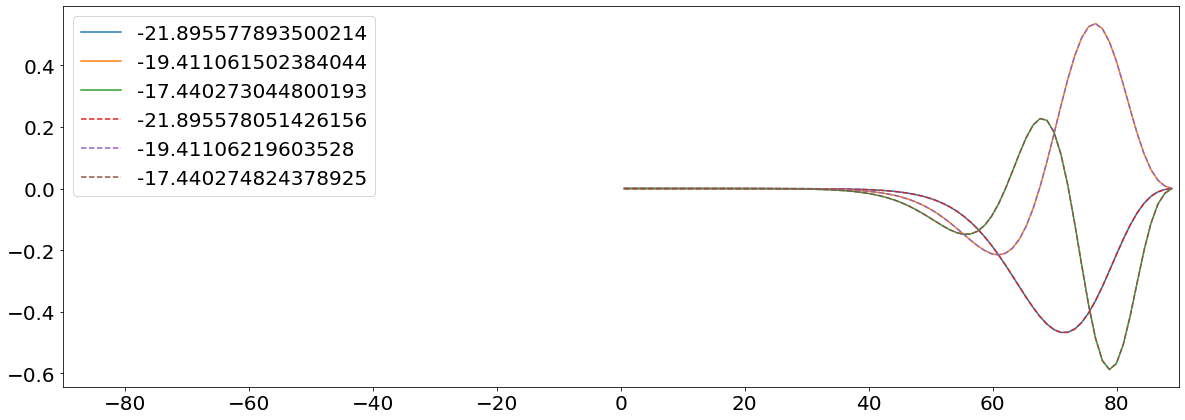

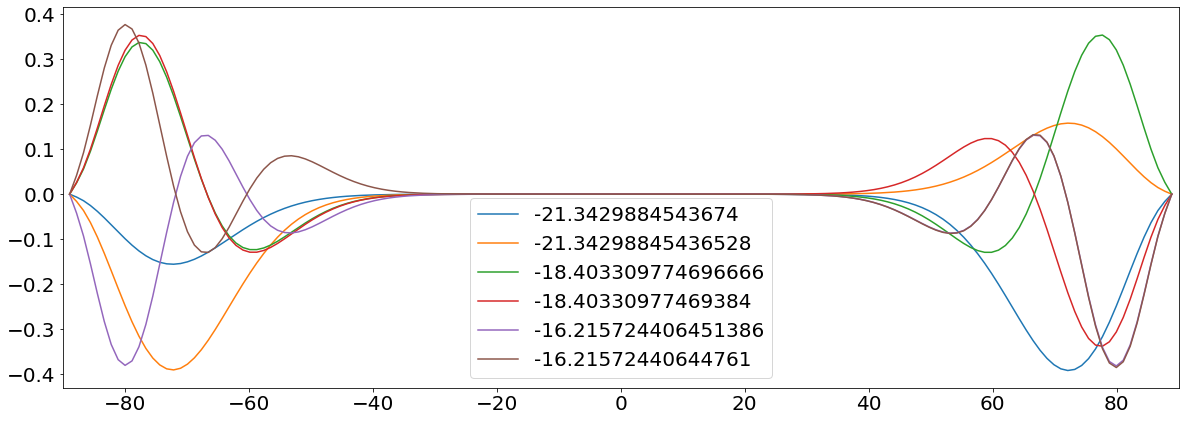

In [301]:
# Plotting the eigenmodes
def plot_eigenmodes(n,ax,lns='-',option=0,two_hemispheres=False):
    ngrid=80
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    
    kprime = np.pi/Hprime
    omegaprime = 2*np.pi / ((-20)*sectoyear) / Omega
    
    C = 2/0.65**2*kprime**2/Nprime**2*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    # Compute matrix and eigendecomposition; we make the approximation that eigenmodes don't change much if chi is changed
    A = set_A(ngrid,m,M,option,two_hemispheres,npoints=3)
    wi,zi,xi=spl.eig(A,left=True)
    #Normalize left eigenvectors so that zj^H * xi = delta_ij
    zi = zi/np.diagonal(np.dot(zi.transpose().conj(),xi))[None,:].conj()
    #Sort eigenvectors by increasing period
    y=set_y(ngrid,two_hemispheres)
    xi=xi[:len(y),np.argsort(np.real(1/wi))]/(1-y[:,None]**2)
    wi=wi[np.argsort(np.real(1/wi))]
    
    
    for i in range(n):
        C0 = 2/0.65**2*kprime**2/Nprime**2
        eigenmode_period = np.real(2*np.pi*C0/(wi[i]*sectoyear*Omega))
        ax.plot(np.arcsin(y)*180.0/np.pi,np.real(xi[:,i]),label=eigenmode_period,linestyle=lns)

    ax.legend()

matplotlib.rcParams.update({'font.size':20})
_,ax=plt.subplots(1,1,figsize=(20,7))
plot_eigenmodes(3,ax,option=1)
plot_eigenmodes(3,ax,lns='--',option=2)
ax.set_xlim(-90,90)

_,ax=plt.subplots(1,1,figsize=(20,7))
plot_eigenmodes(6,ax,option=1,two_hemispheres=True)
ax.set_xlim(-90,90)

In [15]:
# Plotting the eigenmodes
def plot_eigenmodes(n,ax,lns='-',option=0,two_hemispheres=False,old=False):
    ngrid=50
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    
    kprime = np.pi/Hprime
    omegaprime = 2*np.pi / ((-20)*sectoyear) / Omega
    
    C = 2/0.65**2*kprime**2/Nprime**2*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    # Compute matrix and eigendecomposition; we make the approximation that eigenmodes don't change much if chi is changed
    if old:
        A = set_A_old(ngrid,m,M,option,two_hemispheres,npoints=7)
        y = set_y_old(ngrid,two_hemispheres)
    else:
        A = set_A(ngrid,m,M,option,two_hemispheres,npoints=7)
        y = set_y(ngrid,two_hemispheres)
    
    wi,zi,xi=spl.eig(A,left=True)
    #Normalize left eigenvectors so that zj^H * xi = delta_ij
    zi = zi/np.diagonal(np.dot(zi.transpose().conj(),xi))[None,:].conj()
    #Sort eigenvectors by increasing period
    xi=xi[:len(y),np.argsort(np.real(1/wi))]/(1-y[:,None]**2)
    wi=wi[np.argsort(np.real(1/wi))]
    
    subc = A[2*ngrid:,:2*ngrid]
    subd = A[2*ngrid:,2*ngrid:]
    print('lower left a-centrosymmetry : %.3e'%np.max(np.abs(subd-subd[::-1,::-1])))
    
    for i in range(n):
        C0 = 2/0.65**2*kprime**2/Nprime**2
        eigenmode_period = np.real(2*np.pi*C0/(wi[i]*sectoyear*Omega))
        ax.plot(np.arcsin(y)*180.0/np.pi,np.real(xi[:,i]),label=eigenmode_period,linestyle=lns)

    ax.legend()

lower left a-centrosymmetry : 0.000e+00
CPU times: user 152 ms, sys: 6.64 ms, total: 159 ms
Wall time: 192 ms


(-90.0, 90.0)

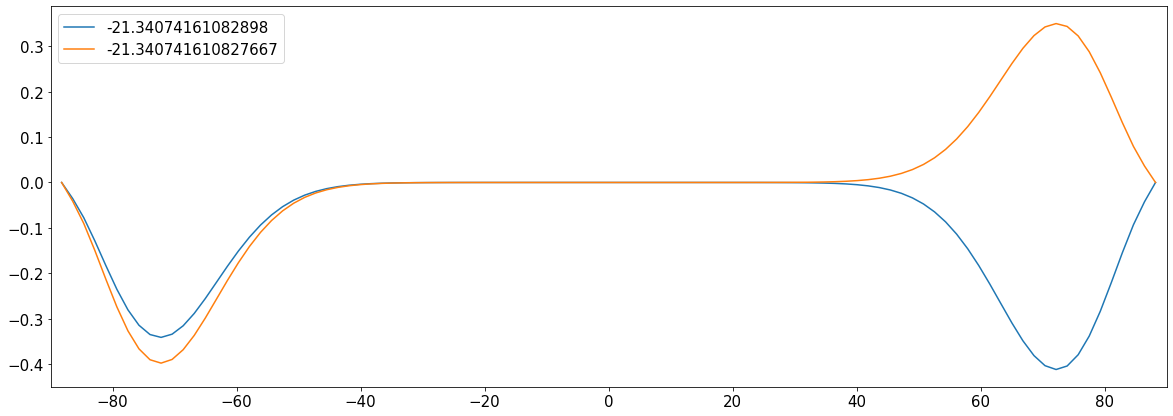

In [10]:
_,ax=plt.subplots(1,1,figsize=(20,7))
plot_eigenmodes(2,ax,option=1,two_hemispheres=True)
ax.set_xlim(-90,90)

lower left a-centrosymmetry : 5.493e-10


(-90.0, 90.0)

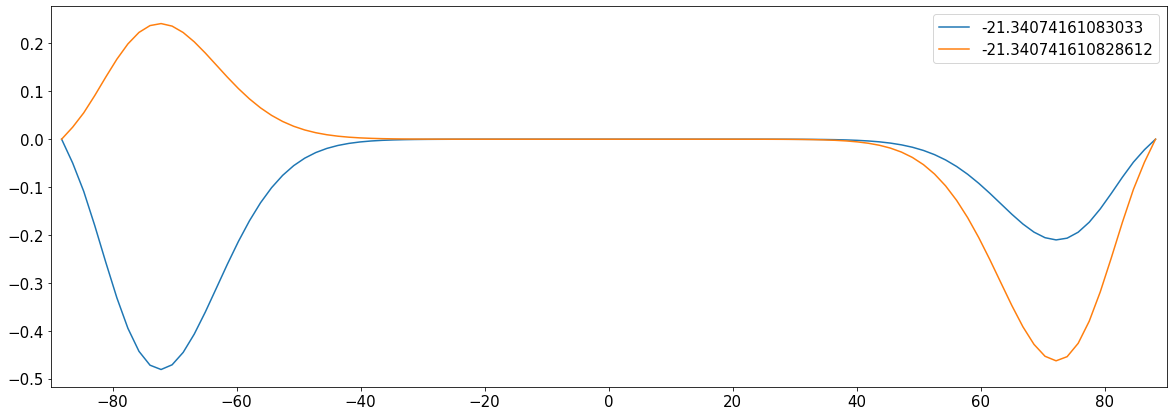

In [16]:
_,ax=plt.subplots(1,1,figsize=(20,7))
plot_eigenmodes(2,ax,option=1,two_hemispheres=True,old=True)
ax.set_xlim(-90,90)

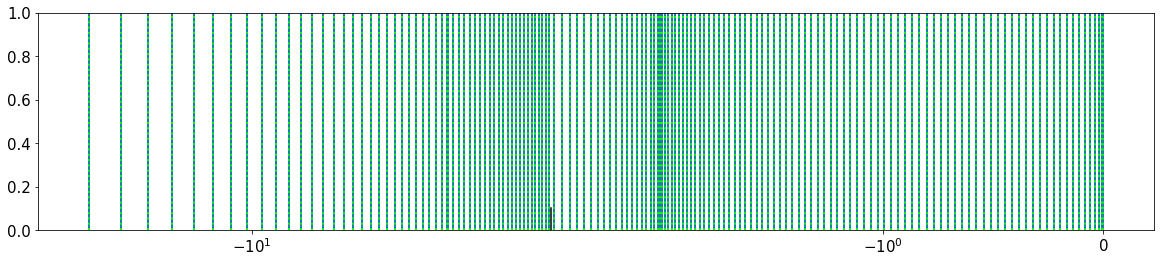

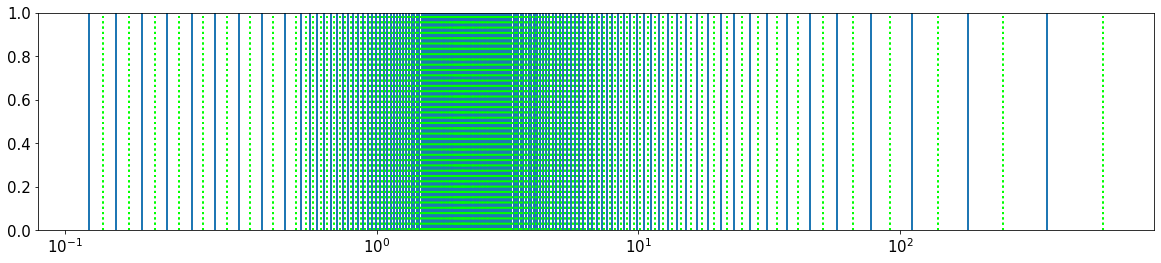

In [65]:
def plot_eigenvals(n1,n2,ax,option=0,two_hemispheres=False,lnt=2.5):
    ngrid=150
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    
    kprime = np.pi/Hprime
    omegaprime = 2*np.pi / ((-20)*sectoyear) / Omega
    
    C = 2/0.65**2*kprime**2/Nprime**2*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    # Compute matrix and eigendecomposition; we make the approximation that eigenmodes don't change much if chi is changed
    A = set_A(ngrid,m,M,option,two_hemispheres)
    wi,zi,xi=spl.eig(A,left=True)
    wi=wi[np.argsort(np.real(1/wi))]
    C0 = 2/0.65**2*kprime**2/Nprime**2
    eigenmode_periods = np.real(2*np.pi*C0/(wi*sectoyear*Omega))
    
    lw=2
    
    for e in eigenmode_periods[n1:n2:2]:
        ax.axvline(e,linewidth=lw)
    for e in eigenmode_periods[n1+1:n2:2]:
        ax.axvline(e,linestyle=':',linewidth=lw,color='lime')
    ax.set_xscale('symlog',base=10,linthresh=lnt)

_,ax=plt.subplots(1,1,figsize=(20,4))
plot_eigenvals(0,300,ax,option=1,two_hemispheres=True)
plot_eigenvals(0,300,ax,option=1,two_hemispheres=True)
ax.plot([-2.5,-2.5],[0,0.1],color='k')
ax.set_ylim(0,1)

_,ax=plt.subplots(1,1,figsize=(20,4))
plot_eigenvals(300,600,ax,option=1,two_hemispheres=True,lnt=0.5)
plot_eigenvals(300,600,ax,option=1,two_hemispheres=True,lnt=0.5)

In [84]:
def get_eigenvals(ngrid,option=0,two_hemispheres=False):
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    
    kprime = np.pi/Hprime
    omegaprime = 2*np.pi / ((-20)*sectoyear) / Omega
    
    C = 2/0.65**2*kprime**2/Nprime**2*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    # Compute matrix and eigendecomposition; we make the approximation that eigenmodes don't change much if chi is changed
    A = set_A(ngrid,m,M,option,two_hemispheres)
    wi,zi,xi=spl.eig(A,left=True)
    #return wi
    wi=wi[np.argsort(np.real(1/wi))]
    C0 = 2/0.65**2*kprime**2/Nprime**2
    eigenmode_periods = np.real(2*np.pi*C0/(wi*sectoyear*Omega))
    return eigenmode_periods

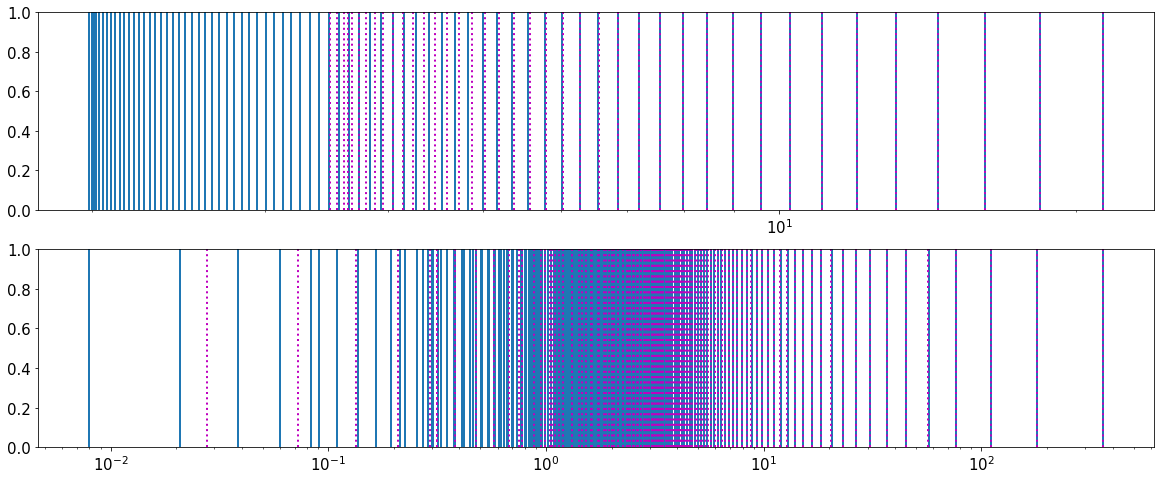

In [98]:
N1=150
N2=80
Ts=get_eigenvals(N1,option=1)
Ts2=get_eigenvals(N2,option=1)
lw=2
_,(ax,ax2)=plt.subplots(2,1,figsize=(20,8))
for T in np.abs(Ts[:N1//2]):
    ax.axvline(T,linewidth=lw)
for T in np.abs(Ts2[:N2//2]):
    ax.axvline(T,linewidth=lw,color='m',linestyle=':')
for T in np.abs(Ts[N1//2:]):
    ax2.axvline(T,linewidth=lw)
for T in np.abs(Ts2[N2//2:]):
    ax2.axvline(T,linewidth=lw,color='m',linestyle=':')
ax.set_xscale('log')
ax2.set_xscale('log')

In [89]:
Ts[49]

-0.07041422651131334

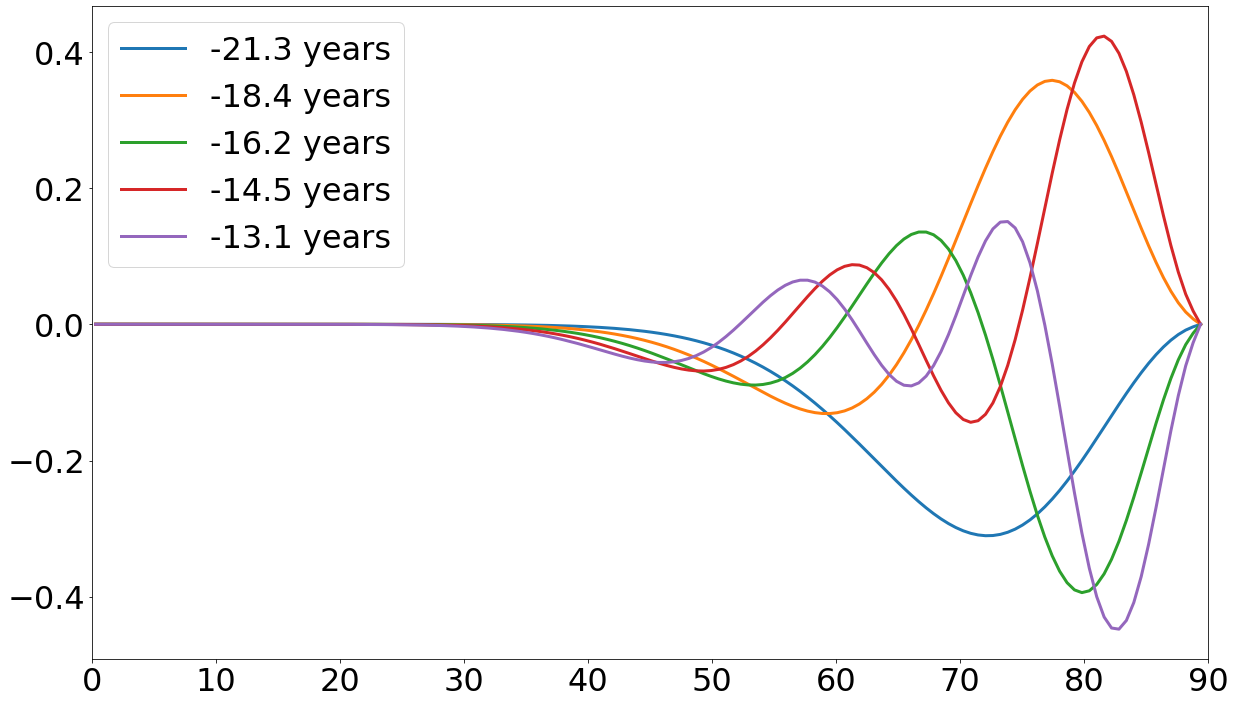

In [122]:
# Plotting the eigenmodes
def plot_eigenmodes(n1,n2,ax,lns='-',option=0,two_hemispheres=False):
    ngrid=150
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    
    kprime = np.pi/Hprime
    omegaprime = 2*np.pi / ((-20)*sectoyear) / Omega
    
    C = 2/0.65**2*kprime**2/Nprime**2*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    # Compute matrix and eigendecomposition; we make the approximation that eigenmodes don't change much if chi is changed
    A = set_A(ngrid,m,M,option,two_hemispheres,npoints=3)
    wi,zi,xi=spl.eig(A,left=True)
    #Normalize left eigenvectors so that zj^H * xi = delta_ij
    zi = zi/np.diagonal(np.dot(zi.transpose().conj(),xi))[None,:].conj()
    #Sort eigenvectors by increasing period
    y=set_y(ngrid,two_hemispheres)
    xi=xi[:len(y),np.argsort(np.real(1/wi))]/(1-y[:,None]**2)
    wi=wi[np.argsort(np.real(1/wi))]
    
    
    for i in range(n1,n2):
        C0 = 2/0.65**2*kprime**2/Nprime**2
        eigenmode_period = np.real(2*np.pi*C0/(wi[i]*sectoyear*Omega))
        ax.plot(np.arcsin(y)*180.0/np.pi,np.real(xi[:,i]),label="%.1f years"%eigenmode_period,linestyle=lns,linewidth=3)

matplotlib.rcParams.update({'font.size':32})
_,ax=plt.subplots(1,1,figsize=(20,12))
plot_eigenmodes(0,5,ax,option=1)
ax.set_xlim(0,90)
ax.legend(loc=2)


# Checking centrosymmetry of A

In [258]:
y=set_y(50,True)
np.max(np.abs(y+y[::-1]))

4.440892098500626e-16

In [262]:
sectoyear = 365.25 * 24 * 60 * 60
Omega = 2*np.pi/86400
kprime = np.pi/Hprime
omegaprime = 2*np.pi / ((-20)*sectoyear) / Omega
C = 2/0.65**2*kprime**2/Nprime**2*omegaprime
chi = 1 +1j*kprime**2/omegaprime*E/Pm
M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)

In [268]:
ngrid=20
A=set_A(ngrid,m,M,option=1,two_hemispheres=True,npoints=7)

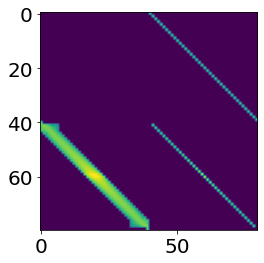

In [269]:
plt.imshow(np.log(np.abs(A)+1e-10))

In [283]:
subc = A[2*ngrid:,:2*ngrid]
subd = A[2*ngrid:,2*ngrid:]
print('lower left a-centrosymmetry : %.3e'%np.max(np.abs(subc-subc[::-1,::-1])))
print('lower right a-centrosymmetry : %.3e'%np.max(np.abs(subd-subd[::-1,::-1])))

lower left a-centrosymmetry : 9.648e-11
lower right a-centrosymmetry : 1.046e-11


In [290]:
y=set_y2(50,True)
np.max(np.abs(y+y[::-1]))

0.0

In [291]:
ngrid=20
A=set_A2(ngrid,m,M,option=1,two_hemispheres=True,npoints=7)
subc = A[2*ngrid:,:2*ngrid]
subd = A[2*ngrid:,2*ngrid:]
print('lower left a-centrosymmetry : %.3e'%np.max(np.abs(subc-subc[::-1,::-1])))
print('lower right a-centrosymmetry : %.3e'%np.max(np.abs(subd-subd[::-1,::-1])))

lower left a-centrosymmetry : 0.000e+00
lower right a-centrosymmetry : 0.000e+00


# Test with second derivative matrix

In [245]:
n = 101
y=np.linspace(0,1,n)
dy=y[1]-y[0]
testA = (1/dy**2)*sps.diags([1, -2, 1], [-1, 0, 1], shape=(n,n)).toarray()
testA[0]=np.zeros(n);testA[n-1]=np.zeros(n)
testA[0,0]=1;testA[n-1,n-1]=1

In [246]:
wi,xi=spl.eig(testA)
order=np.argsort(wi)
wi=wi[order]
xi=xi[:,order]

(-354.25498542623455+0j)
(-246.23318809724665+0j)
(-157.70597371044775+0j)
(-88.76070793840022+0j)
(-39.465431434562106+0j)
(-9.868792685363417+0j)
(1+0j)
(1+0j)


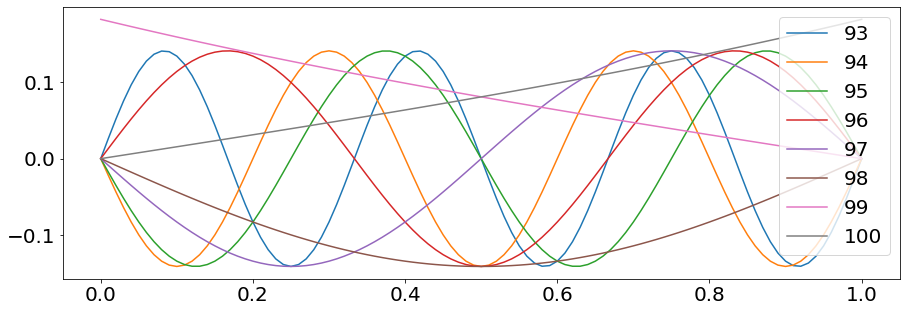

In [247]:
plt.figure(figsize=(15,5))
for i in range(n-8,n):
    print(wi[i])
    plt.plot(y,xi[:,i],label=i)
plt.legend()

In [248]:
syms = xi[:,:-2][:,::-2]
np.max(np.abs(syms-syms[::-1]))

1.1634859742315484e-12

In [249]:
antisyms = xi[:,:-2][:,-2::-2]
np.max(np.abs(antisyms+antisyms[::-1]))

1.731838692583029e-12

In [254]:
np.abs(testA-testA[::-1,::-1]).max()

0.0

# Degree of eigenmodes

In [2]:
def set_y(ngrid,two_sides=False):
    """Sets a y (=cos(latitude)) grid from 0 to 1, nonlinearly spaced, with ngrid points"""
    if two_sides:
        return np.cos(np.linspace(0.,np.pi,2*ngrid+2)[1:-1][::-1])
    else:
        return np.cos(np.linspace(0.,np.pi,2*ngrid+2)[1:-1][::-1][ngrid:]) #exclude the right bound to avoid divisions by 0

def set_A(ngrid,m,M,npoints=7,option=1):
    """ Sets the matrix A of the wave eigenvalue problem (A - C*In)x = 0
    args :
        - ngrid   : int, number of points in y
        - m       : int, spherical harmonic order 
        - M       : float, nondimensional number scaling Magnetic force vs buoyancy force in the MAC balance
        - npoints : number of points for the finite difference stencil (A contains a second order derivative)
    returns :
        - numpy.ndarray of the same shape as x except along the axis, where its length is incremented by 1
    """
    y  = set_y(ngrid)
    D2 = make_D_fornberg(y,2,npoints=npoints) #Matrix of second differentiation
    
    L1 = -np.dot(np.diag(M*(1-y**2)/(y**2)), D2) + np.diag(M*(m**2-1)/(y**2 * (1-y**2)))
    L2 = -np.diag(m/(y**2))
    
    A=np.block([[np.zeros((ngrid,ngrid)),np.eye(ngrid)],[L1,L2]])
    #Enforce Dirichlet boundary conditions
    A[len(y)] = np.zeros(len(A))
    A[-1] = np.zeros(len(A))
    scale=np.abs(A[len(y)+1,0])
    if option == 1: #Dirichlet
        A[len(y),0]=   1
        A[-1,len(y)-1]=1
    elif option == 2: #Neumann; second-order one-sided finite difference @ equator
        A[len(y),:3]  = np.array([-3,4,-1])
        A[-1,len(y)-1]= 1
    # The following avoids numerical errors at the boundaries, that appear when the boundary condition is specified too weakly
    A[len(y)] *= scale
    A[-1]    *= scale
    return A

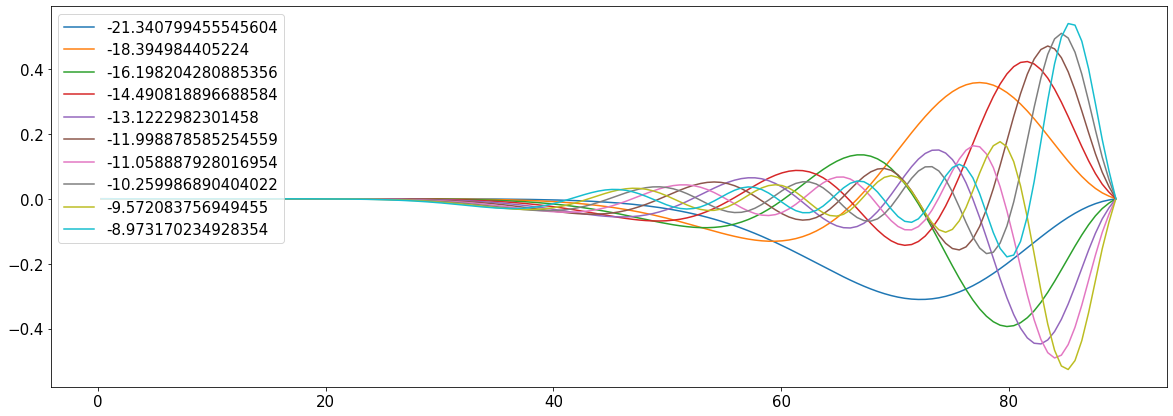

In [5]:
# Plotting the eigenmodes
def plot_eigenmodes(n):
    ngrid=150
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    
    kprime = np.pi/Hprime
    omegaprime = 2*np.pi / ((-20)*sectoyear) / Omega
    
    C = 2/0.65**2*kprime**2/Nprime**2*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    # Compute matrix and eigendecomposition; we make the approximation that eigenmodes don't change much if chi is changed
    A = set_A(ngrid,m,M)
    wi,zi,xi=spl.eig(A,left=True)
    #Normalize left eigenvectors so that zj^H * xi = delta_ij
    zi = zi/np.diagonal(np.dot(zi.transpose().conj(),xi))[None,:].conj()
    #Sort eigenvectors by increasing period
    y=set_y(ngrid)
    xi=xi[:150,np.argsort(np.real(1/wi))]/(1-y[:,None]**2)
    wi=wi[np.argsort(np.real(1/wi))]
    
    _,ax=plt.subplots(1,1,figsize=(20,7))
    for i in range(n):
        C0 = 2/0.65**2*kprime**2/Nprime**2
        eigenmode_period = np.real(2*np.pi*C0/(wi[i]*sectoyear*Omega))
        ax.plot(np.arcsin(y)*180.0/np.pi,np.real(xi[:,i]),label=eigenmode_period)

    ax.legend(loc=2)
plot_eigenmodes(10)

# On one example mode

In [6]:
def get_eigenmode(n):
    ngrid=150
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    
    kprime = np.pi/Hprime
    omegaprime = 2*np.pi / ((-20)*sectoyear) / Omega
    
    C = 2/0.65**2*kprime**2/Nprime**2*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    # Compute matrix and eigendecomposition; we make the approximation that eigenmodes don't change much if chi is changed
    A = set_A(ngrid,m,M)
    wi,zi,xi=spl.eig(A,left=True)
    #Normalize left eigenvectors so that zj^H * xi = delta_ij
    zi = zi/np.diagonal(np.dot(zi.transpose().conj(),xi))[None,:].conj()
    #Sort eigenvectors by increasing period
    y=set_y(ngrid)
    xi=xi[:150,np.argsort(np.real(1/wi))]/(1-y[:,None]**2)
    wi=wi[np.argsort(np.real(1/wi))]
    return np.real(2*np.pi*2/0.65**2*kprime**2/Nprime**2/(wi[n]*sectoyear*Omega)),xi[:,n]
w_test,x_test=get_eigenmode(9)
y = set_y(150)

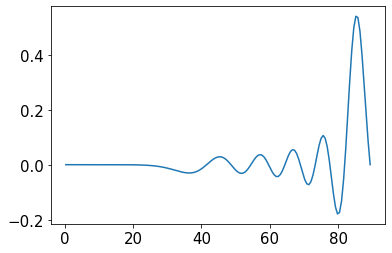

In [8]:
plt.plot(np.arcsin(y)*180.0/np.pi,np.real(x_test))

In [9]:
y_twosides = set_y(150,two_sides=True)
x_antisym = np.real(np.hstack([-x_test[::-1],x_test]))

In [10]:
from pyshtools.legendre import PlmSchmidt_d1

In [11]:
from preprocessingTools import PlmSchmidt_d1_temp
lmax=100
allplm = np.stack( PlmSchmidt_d1_temp(lmax,y_twosides), axis=0 )
m_indices = [(l*(l+1))//2 for l in np.arange(lmax)]
allplm = allplm[:,0,m_indices]
allplm = allplm/np.sqrt(np.trapz(allplm**2,x=y_twosides,axis=0))

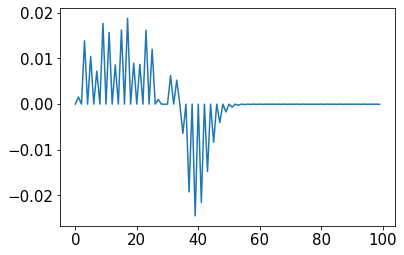

In [12]:
projection = np.trapz(np.real(x_antisym)[:,None] * allplm,x=y_twosides,axis=0)
plt.plot(range(lmax),projection)

Text(0.5, 1.0, 'l=25 legendre polynomial')

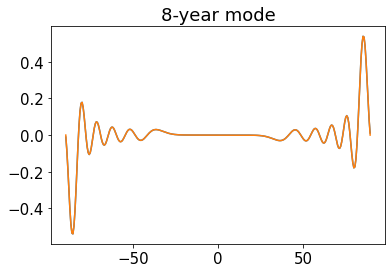

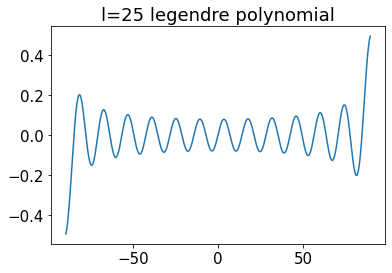

In [43]:
plt.plot(np.arcsin(y_twosides)*180.0/np.pi,np.dot(allplm,projection))
plt.plot(np.arcsin(y_twosides)*180.0/np.pi,np.real(x_antisym))
plt.title("8-year mode")
plt.figure()
plt.plot(np.arcsin(y_twosides)*180.0/np.pi,allplm[:,25]/10)
plt.title("l=25 legendre polynomial")

In [44]:
np.sum(np.arange(lmax)*projection**2)/np.sum(projection**2)

25.821994357230494

## On all modes

In [32]:
from preprocessingTools import PlmSchmidt_d1_temp
def l_from_shape(y,shape,sym=True):
    y_twosides = np.hstack([-y[::-1],y])
    x = np.hstack([shape[::-1],shape]) #Extending it as an antisymmetric eigenmode yields almost exactly the same l
    lmax=100
    allplm = np.stack( PlmSchmidt_d1_temp(lmax,y_twosides), axis=0 )
    m_indices = [(l*(l+1))//2 for l in np.arange(lmax)]
    allpl = allplm[:,0,m_indices]
    allpl = allpl/np.sqrt(np.trapz(allpl**2,x=y_twosides,axis=0))
    
    projections = np.trapz(np.real(x)[:,None] * allpl,x=y_twosides,axis=0)
    return np.sum(np.arange(lmax)*projections**2)/np.sum(projections**2)
    
    

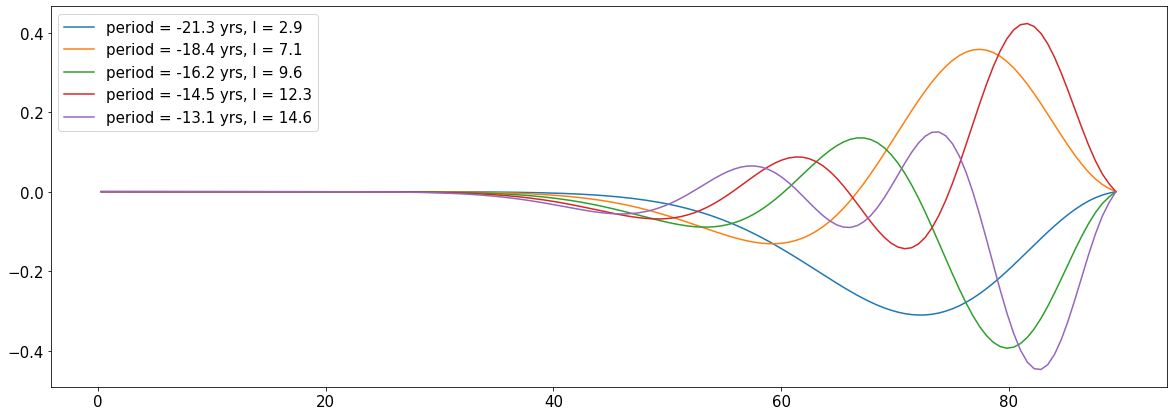

In [48]:
# Plotting the eigenmodes
def plot_eigenmodes(n):
    ngrid=150
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    
    kprime = np.pi/Hprime
    omegaprime = 2*np.pi / ((-20)*sectoyear) / Omega
    
    C = 2/0.65**2*kprime**2/Nprime**2*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    # Compute matrix and eigendecomposition; we make the approximation that eigenmodes don't change much if chi is changed
    A = set_A(ngrid,m,M)
    wi,zi,xi=spl.eig(A,left=True)
    #Normalize left eigenvectors so that zj^H * xi = delta_ij
    zi = zi/np.diagonal(np.dot(zi.transpose().conj(),xi))[None,:].conj()
    #Sort eigenvectors by increasing period
    y=set_y(ngrid)
    xi=xi[:150,np.argsort(np.real(1/wi))]/(1-y[:,None]**2)
    wi=wi[np.argsort(np.real(1/wi))]
    
    _,ax=plt.subplots(1,1,figsize=(20,7))
    for i in range(n):
        C0 = 2/0.65**2*kprime**2/Nprime**2
        eigenmode_period = np.real(2*np.pi*C0/(wi[i]*sectoyear*Omega))
        ax.plot(np.arcsin(y)*180.0/np.pi,np.real(xi[:,i]),label="period = %.1f yrs, l = %.1f"%(eigenmode_period,l_from_shape(y,np.real(xi[:,i]),sym=True)))

    ax.legend(loc=2)
plot_eigenmodes(5)

In [46]:
180/15

12.0